<io>
    compustat과 crsp 데이터를 기반으로 기업의 월간 수익률을 예측하는 모형을 구성해 보고자 한다. <br>
    딥러닝 모델 중 Gan 모형이라는 것을 이용하여 예측을 해 보고자 하며, 대용치로 LSTM과, CNN 모형을 이용하였다. <br>
    또한 GPU 기반 tensorflow에 연결하는 방식을 통하여 계산 시간 등을 단축시키고자 하며, Gan 모델이 아직 엄밀하게 구성이 되지는 않았으나, 기본적인 원리를 바탕으로 <br>
    어느 정도 예측 성과를 보이는지를 out-of-sampling으로 검증하고 이후 개선하기 위한 방법을 찾아보고자 한다. (추가 논문 등이 필요할 듯) <br>

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('mon_ret.csv')
df1 = pd.read_csv('compustat_all.csv')
df1['cusip'] = df1['cusip'].apply(lambda x: str(x)[:-1] if pd.notna(x) and len(str(x)) == 9 else x)
df['date'] = pd.to_datetime(df['date'])
df['fyear'] = df['date'].dt.year

df1 = df1[['gvkey','fyear', 'cusip', 'at', 'csho', 'icapt', 'intan', 'ni', 'pi', 'sale', 'mkvalt']]
df1['lnat'] = df1['at'].apply(lambda x : np.log(1+x))

df2 = df.merge(df1, left_on=['fyear', 'CUSIP'], right_on=['fyear', 'cusip'], how='left')

df2['RET'] = pd.to_numeric(df2['RET'], errors='coerce')
df2['std'] = df2.groupby('CUSIP')['RET'].transform(lambda x: x.rolling(window=8).std())

df2.to_csv('crsp_compustat.csv',index=False)

In [1]:
import pandas as pd
df2 = pd.read_csv('crsp_compustat.csv') #CUSIP 기준으로 병합한 crsp_compustat 연결 파일 
df2['date'] = pd.to_datetime(df2['date'])
df2['yearmonth'] = df2['date'].dt.strftime('%Y%m') #Kenneth R. French 로 부터 Fama French 요인 및 무위험 이자율 월 데이터 불러와서, 병합하기 위해서 만듬

df1 = pd.read_csv('F-F.csv')
df1['Unnamed: 0'] = pd.to_datetime(df1['Unnamed: 0'], format = '%Y%m')
df1['yearmonth'] = df1['Unnamed: 0'].dt.strftime('%Y%m')

df2 = df2.merge(df1, left_on = ['yearmonth'], right_on = ['yearmonth'], how='left')
df2 = df2.drop(columns=['yearmonth', 'Unnamed: 0'])

df2['ROA'] = df2['ni']/df2['at']
df2['PBR'] = df2['mkvalt']/df2['at']

# y 변수 : sharp ratio, RET-RF/STD (RF는 1개월 만기 국채)
# x변수 : ROA(매출액 대비 자산), PBR(시가총액 대비 자산), icapt(투자자본), intan(유형자산), ni(순수익), pi(세전소득), sale(매출액), lnat(size, 로그자산)
#각 x변수 즉 특성 변수에 대해서 연도별 퀀타일 화 해주기 (0~1 값으로 scaling 하여 이후 딥러닝 등 적합에 편하게 하기 위해)
df2['ROA'] = df2.groupby('date')['ROA'].rank() / df2.groupby('date')['ROA'].transform('count')
df2['PBR'] = df2.groupby('date')['PBR'].rank() / df2.groupby('date')['PBR'].transform('count')
df2['icapt'] = df2.groupby('date')['icapt'].rank() / df2.groupby('date')['icapt'].transform('count')
df2['intan'] = df2.groupby('date')['intan'].rank() / df2.groupby('date')['intan'].transform('count')
df2['ni'] = df2.groupby('date')['ni'].rank() / df2.groupby('date')['ni'].transform('count')
df2['pi'] = df2.groupby('date')['pi'].rank() / df2.groupby('date')['pi'].transform('count')
df2['sale'] = df2.groupby('sale')['pi'].rank() / df2.groupby('sale')['pi'].transform('count')
df2['size'] = df2.groupby('lnat')['pi'].rank() / df2.groupby('lnat')['pi'].transform('count')

df3 = df2.copy()


In [2]:
df3.to_csv('ready.csv', index=False)

<io>
    GAN 모형을 사용하기 위하여 생성기와, 판별기를 사용자 정의 함수를 이용하여 형성하였다. <br>
    생성기 함수는 LeakyReLU를 활성화 함수를 사용하여 입력 차원을 기준으로 (본 분석에서는 위의 8개 변수를 기준으로 월간 수익률 RET 와 적합시킬 예정) <br>
    128 - 256 - 512 로 레이어를 이어 준 다음, 0과 1 사이의 입력값으로 해놓았기에, sigmoid를 사용하였다.<br>
<br>
    판별기의 input_dim은 build_generator 로 나온 결과값에 대하여 입력값을 받을 예정이며, 밑의 build_gan에 연결이 되어 있다. <br>
    이전의 autoencoder 에서 한 방식인 class로 묶어서 한번에 하지 않고, 이번에는 사용자 정의 함수로 나누어서 한 결과이기에 약간 차이가 있고 <br>
    LeakyReLU함수를 이용하여 차원 축소를 하였다. 
<br> 
    이후 build_gan 모형은 판별기의 가중치에 따른 갱신을 막고, 생성기와, 판별기를 바탕으로 모델을 형성한다.
    

In [1]:
#gpu 사용여부 체크
import tensorflow as tf

print('gpu 여부 : ', tf.config.experimental.list_physical_devices('GPU'))

2024-02-03 14:16:25.780252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 14:16:25.780283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 14:16:25.781301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 14:16:25.787327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 14:16:26.353826: W tensorflow/compiler/tf2

gpu 여부 :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-03 14:16:27.037510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 14:16:27.070788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 14:16:27.071016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### GAN

<io>
    GAN 모형은 배치를 500~5000까지 늘려가면서 임의의 랜덤한 값을 추출하고, 이를 통해 생성, 판별자를 학습시키면서 가장 적합한 모델을 찾고자 한다. <br>
    epochs는 1000으로 학습을 시킨 후, 컴파일된 모형을 바탕으로 test_set(05~07) 데이터를 검증하여 RMSE 가 가장 낮은 모형을 최적 모형으로 선정하고자 한다. 

In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Flatten
from tensorflow.keras.optimizers import Adam
import itertools

def build_generator(input_dim, output_dim):
    generator = Sequential()
    generator.add(Dense(128, input_dim=input_dim))
    generator.add(LeakyReLU(0.2)) #음수를 약간 허용해서 희소 gradient를 방지하기 위함
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Dense(256))
    generator.add(LeakyReLU(0.2))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(output_dim, activation='sigmoid'))
    return generator

def build_discriminator(input_dim):
    discriminator = Sequential()
    discriminator.add(Dense(512, input_dim=input_dim))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(1, activation='linear')) #0,1 범위가 ret가 아니므로 
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return discriminator

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(generator.input_shape[1],))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
   return np.sqrt(mean_squared_error(y_test, y_predict))

df3 = pd.read_csv('ready.csv')
xx = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
com7 = [list(x) for x in itertools.combinations(xx, 7)]
com6 = [list(x) for x in itertools.combinations(xx, 6)]
com5 = [list(x) for x in itertools.combinations(xx, 5)]
x_all = [xx]#com7+com6+com5+[xx]
for ii in range(0, len(x_all)): #46,69,92로 4개 창 띄워서 병렬로 돌릴꺼임, 모델만 중요하니까 sh 만들어놓음
    x = x_all[ii]
    name = ''.join([word[0:2] for word in x]) #모델 명을 각 변수명 앞 두자리 따서 만듬
    df2 = df3[x + ['RET']+['fyear']].copy()
    df2 = df2.dropna()
    
    train_df = df2[df2['fyear'].between(1993, 2004)]
    test_df = df2[df2['fyear'].between(2005, 2007)]
    out_df = df2[df2['fyear'].between(2008, 2022)]
    
    
    train_df_x = train_df[x].values
    train_df_y = train_df['RET'].values
    
    generator = build_generator(input_dim=len(x), output_dim=1)
    discriminator = build_discriminator(input_dim=1)
    gan = build_gan(generator, discriminator)
    
    # GAN 모델 학습
    epochs = 1000
    best_performance = float('inf')
    for m in range(10):
        batch_size = 500*(m+1)
        indices = np.random.randint(0, len(train_df), size=batch_size) #배치크기만큼 랜덤한 위치, 즉 인덱스 생성
        batch_train_df_x = train_df_x[indices]
        batch_train_df_y = train_df_y[indices].reshape((batch_size, 1)) #x,y에 대해 그 위치 값들 추출
        
        for epoch in range(epochs):
            # 생성기로 가짜데이터 생성
            generated_samples = generator.predict(batch_train_df_x)
            # 판별자 학습 
            discriminator.train_on_batch(batch_train_df_y, np.ones((batch_size, 1)))
            discriminator.train_on_batch(generated_samples, np.zeros((batch_size, 1)))
            # gan 모델에 학습된 discriminator랑 generator 바탕으로 적용시킴
            gan.train_on_batch(batch_train_df_x, np.ones((batch_size, 1)))
        test_x = test_df[x].values
        test_y = test_df['RET'].values
        test_generated = gan.predict(test_x)
        now_RMSE = RMSE(test_y, test_generated)
    
        if now_RMSE < best_performance:
            best_performance = now_RMSE
            generator.save('best_model'+name+'.h5')

2024-02-03 13:51:44.460009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 13:51:44.460248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 13:51:44.460419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

16/16 [==============================] - 2s 726us/step


2024-02-03 13:51:49.048069: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f01f05afae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 13:51:49.048099: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-03 13:51:49.056159: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-03 13:51:50.288057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1706935910.352740   10281 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 0s 721us/step


/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 0s 613us/step


/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/79 [..............................] - ETA: 0s

/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 0s 596us/step


/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4714/4714 [==============================] - 3s 711us/step


### LSTM

<io>
    LSTM 모형은 배치를 500~5000까지 늘려가면서 이전과 유사하게 학습을 하는데, 1000번의 epochs 중 조기종료 콜백을 설정하여 중간에 학습을 그만두고자 하였다. <br>
    이전 GAN 모형과 최대한 유사하게 구성을 하고자 하엿으나, 이전 GAN 모형을 할 시, 너무 많은 학습시간과 쓸데없는 학습 등이 문제가 되는 듯 하여 개선하기 위해 약간만 수정을 해 보았다. <br>

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM,Dense, LeakyReLU, BatchNormalization, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping #1000이라는 epochs가 너무 큰거 같아서, 중단 콜백 설정예정
import itertools

# LSTM 모델 생성 함수
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
   return np.sqrt(mean_squared_error(y_test, y_predict))

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상 성능 지표
                               min_delta=0.0005,  # 개선으로 간주되는 최소 변화량
                               patience=20,  # 지정된 에폭 동안 개선이 없을 경우 학습 종료
                               verbose=1,  # 조기 종료 시 로그 출력
                               restore_best_weights=True)  # 가장 좋은 모델의 가중치로 복원

df3 = pd.read_csv('ready.csv')
xx = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
com7 = [list(x) for x in itertools.combinations(xx, 7)]
com6 = [list(x) for x in itertools.combinations(xx, 6)]
com5 = [list(x) for x in itertools.combinations(xx, 5)]
x_all = [xx]#com7+com6+com5+[xx]
for ii in range(0, len(x_all)): #46,69,92로 4개 창 띄워서 병렬로 돌릴꺼임, 모델만 중요하니까 sh 만들어놓음
    x = x_all[ii]
    name = ''.join([word[0:2] for word in x]) #모델 명을 각 변수명 앞 두자리 따서 만듬
    df2 = df3[x + ['RET']+['fyear']].copy()
    df2 = df2.dropna()
    
    train_df = df2[df2['fyear'].between(1993, 2004)]
    test_df = df2[df2['fyear'].between(2005, 2007)]
    out_df = df2[df2['fyear'].between(2008, 2022)]
    
    train_df_x = train_df[x].values
    train_df_y = train_df['RET'].values

    test_x = test_df[x].values #검증 밑 조기종료 조건으로도 쓸 검증 셋
    test_y = test_df['RET'].values

    # LSTM 모델 학습
    input_shape = (train_df_x.shape[1], 1)
    lstm_model = build_lstm(input_shape) 
    epochs = 1000
    best_performance = float('inf')
    for m in range(10): #학습
        batch_size = 500*(m+1)
        #조기종료도 설정해줌 callbacks로
        lstm_model.fit(train_df_x, train_df_y, epochs=epochs, batch_size=batch_size,
                       validation_data=(test_x, test_y), callbacks=[early_stopping]) #test셋을 검증데이터로 씀
 
        test_generated = lstm_model.predict(test_x)
        now_RMSE = RMSE(test_y, test_generated)
    
        if now_RMSE < best_performance: #검증데이터 기반으로 산출된 최적 모델에서 가장 rmse 작은 모델 찾음
            best_performance = now_RMSE
            lstm_model.save(f'best_LSTM_model_{name}.h5')

2024-02-03 14:16:35.297365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 14:16:35.297697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 14:16:35.297874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/1000


2024-02-03 14:16:38.699132: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-03 14:16:40.285887: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc4901d59b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 14:16:40.285909: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-03 14:16:40.289175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706937400.357666  756419 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


796/796 [==============================] - 7s 3ms/step - loss: 0.0462 - val_loss: 0.0161
Epoch 2/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0461 - val_loss: 0.0165
Epoch 3/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0460 - val_loss: 0.0165
Epoch 4/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0459 - val_loss: 0.0163
Epoch 5/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0459 - val_loss: 0.0162
Epoch 6/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 7/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0458 - val_loss: 0.0163
Epoch 8/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 9/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 10/1000
796/796 [==============================] - 2s 3ms/step - loss: 0.0457 - val_loss:

/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


398/398 [==============================] - 1s 3ms/step - loss: 0.0461 - val_loss: 0.0165
Epoch 2/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0460 - val_loss: 0.0162
Epoch 3/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0460 - val_loss: 0.0162
Epoch 4/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0459 - val_loss: 0.0162
Epoch 5/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0459 - val_loss: 0.0164
Epoch 6/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0459 - val_loss: 0.0162
Epoch 7/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0163
Epoch 8/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 9/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0163
Epoch 10/1000
398/398 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss:

### CNN

<io>
    CNN 모형도 이전의 LSTM 모형과 유사하게 구축을 하였으며, <br>
    1차원 컨볼루션을 적용하여, 64개의 특징을 학습하도록 하였다. 이후 1차원 층으로 연결하고, 완전연결 (Dense) 층으로 연결하여 최종 출력값인 RET를 예측하도록 구성하였다.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import itertools

# CNN
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# RMSE 계산 함수
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상 성능 지표
                               min_delta=0.0005,  # 개선으로 간주되는 최소 변화량
                               patience=20,  # 지정된 에폭 동안 개선이 없을 경우 학습 종료
                               verbose=1,  # 조기 종료 시 로그 출력
                               restore_best_weights=True)  # 가장 좋은 모델의 가중치로 복원


df3 = pd.read_csv('ready.csv')
xx = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
com7 = [list(x) for x in itertools.combinations(xx, 7)]
com6 = [list(x) for x in itertools.combinations(xx, 6)]
com5 = [list(x) for x in itertools.combinations(xx, 5)]
x_all = [xx]#com7+com6+com5+[xx]
for ii in range(0, len(x_all)): #46,69,92로 4개 창 띄워서 병렬로 돌릴꺼임, 모델만 중요하니까 sh 만들어놓음
    x = x_all[ii]
    name = ''.join([word[0:2] for word in x]) #모델 명을 각 변수명 앞 두자리 따서 만듬
    df2 = df3[x + ['RET']+['fyear']].copy()
    df2 = df2.dropna()
    
    train_df = df2[df2['fyear'].between(1993, 2004)]
    test_df = df2[df2['fyear'].between(2005, 2007)]
    out_df = df2[df2['fyear'].between(2008, 2022)]
    
    train_df_x = train_df[x].values
    train_df_y = train_df['RET'].values

    test_x = test_df[x].values #검증 밑 조기종료 조건으로도 쓸 검증 셋
    test_y = test_df['RET'].values

    # CNN모델 학습
    input_shape = (train_df_x.shape[1], 1)
    cnn_model = build_cnn(input_shape)
    epochs = 1000
    best_performance = float('inf')
    for m in range(10): #학습
        batch_size = 500*(m+1)
        #조기종료도 설정해줌 callbacks로
        cnn_model.fit(train_df_x, train_df_y, epochs=1000, batch_size=batch_size,
                      validation_data=(test_x, test_y), callbacks=[early_stopping])

        test_generated = cnn_model.predict(test_x)
        now_RMSE = RMSE(test_y, test_generated)
    
        if now_RMSE < best_performance: #검증데이터 기반으로 산출된 최적 모델에서 가장 rmse 작은 모델 찾음
            best_performance = now_RMSE
            lstm_model.save(f'best_CNN_model_{name}.h5')

Epoch 1/1000
796/796 [==============================] - 4s 2ms/step - loss: 0.0459 - val_loss: 0.0162
Epoch 2/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 3/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0161
Epoch 4/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0162
Epoch 5/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 6/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0164
Epoch 7/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 8/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0167
Epoch 9/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0163
Epoch 10/1000
796/796 [==============================] - 1s 2ms/step - loss: 0.045

/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


398/398 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0162
Epoch 2/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0162
Epoch 3/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0163
Epoch 4/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0165
Epoch 5/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 6/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 7/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0167
Epoch 8/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0163
Epoch 9/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0164
Epoch 10/1000
398/398 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss:

/home/siro8458/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


266/266 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0163
Epoch 2/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0162
Epoch 3/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 4/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0163
Epoch 5/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0165
Epoch 6/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0166
Epoch 7/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0162
Epoch 8/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0164
Epoch 9/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0164
Epoch 10/1000
266/266 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss:

### 혹시나 조합내에서 반복문 끊겨서 시작 지점 모를때 조합 기준으로 몇번재인지 찾는 코드

In [3]:
#ROicinpisasi
import itertools

xx = ['ROA', 'PBR', 'icapt', 'intan', 'ni', 'pi', 'sale', 'size']

com7 = [list(x) for x in itertools.combinations(xx, 7)]
com6 = [list(x) for x in itertools.combinations(xx, 6)]
com5 = [list(x) for x in itertools.combinations(xx, 5)]
x_all = com7 + com6 + com5

target = ['icapt', 'intan', 'ni', 'pi', 'sale']

index = None
for i, combo in enumerate(x_all):
    if set(combo) == set(target):
        index = i
        break

index

86

### 각 test셋에 대하여 적합시킨 최적의 모델을 기반으로 outofsampling에 대해 예측을 수행 후, 성능을 비교해보자

In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU, BatchNormalization, Input,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import itertools
import os
import re

2024-02-03 14:25:43.765694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 14:25:43.765725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 14:25:43.766754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 14:25:43.772430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 14:25:44.355636: W tensorflow/compiler/tf2

In [ ]:
# CNN, LSTM, Gan
models = ['LSTM'] #'CNN','GAN'

files = os.listdir('.')

for model in models:
    pattern = re.compile(rf'best_{model}_model_(.+?)\.h5')
    model_files = [f for f in files if pattern.match(f)]
    
    df3 = pd.read_csv('ready.csv')
    
    for ii in range(0, len(model_files)):
        model_file = model_files[ii]
        xvar = pattern.match(model_file).group(1)
        num_x = int(len(xvar)/2)
        each_x = [xvar[2*i:2*(i+1)] for i in range(0, num_x)]
        
        xx = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
        x = list(set([item for item in xx for each in each_x if item.startswith(each)])) #each_x로 추출한 모델명 2글자씩을 xx라는 전체 x변수들 각각이 저 단어로 시작하는 친구들만 뽑고 list로 만듬
        df2 = df3[x + ['RET','date','fyear','Mkt-RF', 'SMB','HML', 'RF','CUSIP','lnat','mkvalt']].copy()
        df2 = df2.dropna(subset=x + ['RET']+['fyear'])
        out_df = df2[df2['fyear'].between(2008, 2022)]
        
        out_x = out_df[x].values #검증 밑 조기종료 조건으로도 쓸 검증 셋
        out_y = out_df['RET'].values
        
        use_model = load_model(model_file)
        predictions = use_model.predict(out_x)
        pre = pd.DataFrame(predictions, columns=['predict'])
        out_df = pd.concat([out_df, pre], axis=1)
        out_df['std'] = out_df.groupby('CUSIP')['predict'].transform(lambda x: x.rolling(window=8).std())
        out_df['sharp'] = (out_df['predict'] - out_df['RF'])/out_df['std']
        
        model_name = model+'('+str(num_x)+')'+xvar
        out_df.to_csv('./pre/'+model_name+'.csv', index=False, encoding='cp949')

In [5]:
#Gan 모형의 생성자를 저장을 밑의 형식으로 해놓아서 따로 빼서 코드를 짬, 경고 문구는 학습용이 아닌 예측용이라, 가중치만 있으면 되어서 무시해도됨
files = os.listdir('.')

df3 = pd.read_csv('ready.csv')
    
pattern = re.compile(rf'best_model(.+?)\.h5')
model_files = [f for f in files if pattern.match(f)]

for ii in range(0, len(model_files)):
    model_file = model_files[ii]
    xvar = pattern.match(model_file).group(1)
    num_x = int(len(xvar)/2)
    each_x = [xvar[2*i:2*(i+1)] for i in range(0, num_x)]
    
    xx = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
    x = list(set([item for item in xx for each in each_x if item.startswith(each)])) #each_x로 추출한 모델명 2글자씩을 xx라는 전체 x변수들 각각이 저 단어로 시작하는 친구들만 뽑고 list로 만듬
    df2 = df3[x + ['RET','date','fyear','Mkt-RF', 'SMB','HML', 'RF','CUSIP','lnat','mkvalt']].copy()
    df2 = df2.dropna(subset=x + ['RET']+['fyear'])
    out_df = df2[df2['fyear'].between(2008, 2022)]
    
    out_x = out_df[x].values #검증 밑 조기종료 조건으로도 쓸 검증 셋
    out_y = out_df['RET'].values
    
    use_model = load_model(model_file)
    predictions = use_model.predict(out_x)
    pre = pd.DataFrame(predictions, columns=['predict'])
    out_df = pd.concat([out_df, pre], axis=1)
    out_df['std'] = out_df.groupby('CUSIP')['predict'].transform(lambda x: x.rolling(window=8).std())
    out_df['sharp'] = (out_df['predict'] - out_df['RF'])/out_df['std']
    
    model_name = 'GAN'+'('+str(num_x)+')'+xvar
    out_df.to_csv('./pre/'+model_name+'.csv', index=False, encoding='cp949')

2024-02-02 22:22:32.115437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 22:22:32.221872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 22:22:32.222114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

23893/23893 [==============================] - 14s 598us/step


In [5]:
#Gan 모형의 생성자를 저장을 밑의 형식으로 해놓아서 따로 빼서 코드를 짬, 경고 문구는 학습용이 아닌 예측용이라, 가중치만 있으면 되어서 무시해도됨

df3 = pd.read_csv('ready.csv')

model_files = ['best_CNN_model_ROPBicinnipisasi.h5', 'best_LSTM_model_ROPBicinnipisasi.h5', 'best_modelROPBicinnipisasi.h5']
mon1 = ['CNN', 'LSTM', 'GAN']

for ii in range(0, len(model_files)):
    model_file = model_files[ii]
    mon = mon1[ii]
    x = ['ROA', 'PBR', 'icapt','intan', 'ni', 'pi', 'sale', 'size']
    df2 = df3[x + ['RET','date','fyear','Mkt-RF', 'SMB','HML', 'RF','CUSIP','lnat','mkvalt']].copy()
    df2 = df2.dropna(subset=x + ['RET']+['fyear'])
    out_df = df2[df2['fyear'].between(2008, 2022)]
    
    out_x = out_df[x].values #검증 밑 조기종료 조건으로도 쓸 검증 셋
    out_y = out_df['RET'].values
    
    use_model = load_model(model_file)
    predictions = use_model.predict(out_x)
    pre = pd.DataFrame(predictions, columns=['predict'])
    out_df = pd.concat([out_df, pre], axis=1)
    out_df['std'] = out_df.groupby('CUSIP')['predict'].transform(lambda x: x.rolling(window=8).std())
    out_df['sharp'] = (out_df['predict'] - out_df['RF'])/out_df['std']
    
    model_name = mon+'('+str(8)+')'+'ROPBicinnipisasi'
    out_df.to_csv('./pre/'+model_name+'.csv', index=False, encoding='cp949')

21320/21320 [==============================] - 13s 579us/step


In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
#결과내역 저장할 데이터프레임
result = pd.DataFrame(columns=['model', 'sharpe', 'R^2', 'RMSE'])

files = os.listdir('./pre/')

for i in range(0, len(files)):
    df = pd.read_csv('./pre/'+files[i], encoding='cp949', low_memory=False)
    ### 시가총액 기준으로 상/하위 25%의 포트폴리오를 구성하며, 이를 토대로 sharpe ratio, R^2, MRSE 등을 계산해봄
    ### 시가총액이 큰 주식에 가중치를 크게 두는 안정적인 포트폴리오를 구성해봄
    df['mkvalt_mean'] = df.groupby('CUSIP')['mkvalt'].transform('mean') #cusip별 시가총액의 평균
    upper = df['mkvalt_mean'].quantile(0.75)
    lower = df['mkvalt_mean'].quantile(0.25)
    pf = pd.concat([df[df['mkvalt_mean']>=upper], df[df['mkvalt_mean']<=lower]])
    pf['weight'] = pf['mkvalt_mean']/pf.groupby('CUSIP')['mkvalt'].mean().sum()
    pf1 = pf[['RET', 'predict','RF','std','weight']].copy()
    pf1 = pf1.dropna()
    rf_mean = pf1['RF'].mean()
    weight_predict = (pf1['predict']*pf1['weight']).sum()
    weight_std = np.sqrt((pf1['std']**2 * pf1['weight']**2).sum())
    pf_sharp = (weight_predict - rf_mean) / weight_std
    name = files[i].replace(".csv", "")
    RMSE = np.sqrt(mean_squared_error(pf1['RET'], pf1['predict']))
    R2 = r2_score(pf1['RET'], pf1['predict'])
    result.loc[i, 'model'] = name
    result.loc[i, 'sharpe'] = pf_sharp
    result.loc[i, 'R^2'] = R2
    result.loc[i, 'RMSE'] = RMSE


In [15]:
result

,model,sharpe,R^2,RMSE
0,LSTM(6)ROPBicnisasi,49.332427,-0.010789,0.211864
1,LSTM(6)ROPBicpisasi,151.872575,-0.007535,0.211523
2,LSTM(6)ROPBinnipisa,232.615547,-0.009334,0.214047
3,LSTM(6)ROPBinnipisi,39.580944,-0.01141,0.214267
4,LSTM(6)ROPBinnisasi,75.838961,-0.012661,0.2144
...,...,...,...,...
274,GAN(6)ROinnipisasi,544.034384,-6.6951,0.567977
275,GAN(6)ROPBicinnipi,245.042947,-2.000826,0.369073
276,GAN(6)ROPBicinnisa,568.514546,-8.11762,0.643328
277,GAN(6)ROPBicinnisi,62.927799,-0.55456,0.265641


In [16]:
result.to_csv('predict.csv', index=False, encoding='cp949')

In [17]:
import re
import pandas as pd

result = pd.read_csv('predict.csv', encoding='cp949')
result['name'] = result['model'].apply(lambda x: x.split('(')[0])
result['num'] = result['model'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1))

In [41]:
result.head()

,model,sharpe,R^2,RMSE,name,num
0,LSTM(6)ROPBicnisasi,49.332427,-0.010789,0.211864,LSTM,6
1,LSTM(6)ROPBicpisasi,151.872575,-0.007535,0.211523,LSTM,6
2,LSTM(6)ROPBinnipisa,232.615547,-0.009334,0.214047,LSTM,6
3,LSTM(6)ROPBinnipisi,39.580944,-0.011410,0.214267,LSTM,6
4,LSTM(6)ROPBinnisasi,75.838961,-0.012661,0.214400,LSTM,6


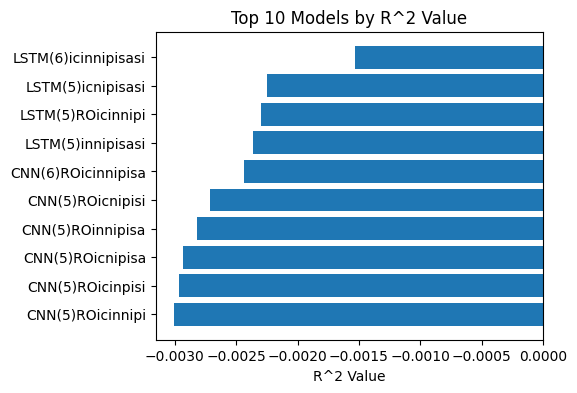

In [36]:
import matplotlib.pyplot as plt

result_R2 = result.sort_values('R^2', ascending=False).head(10)
plt.figure(figsize=(5, 4))
plt.barh(result_R2['model'], result_R2['R^2'])
plt.xlabel('R^2 Value')
plt.title('Top 10 Models by R^2 Value')
plt.gca().invert_yaxis()
plt.show()


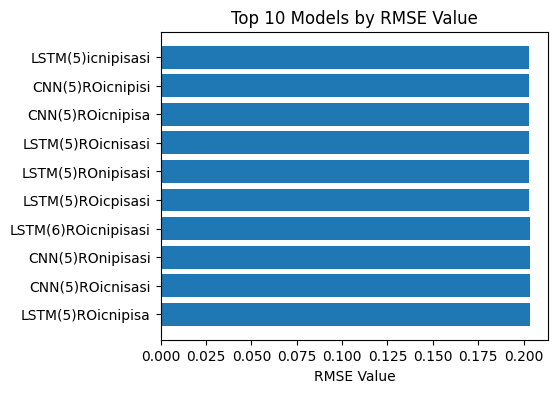

In [43]:
import matplotlib.pyplot as plt

result_RMSE = result.sort_values('RMSE', ascending=True).head(10)
plt.figure(figsize=(5, 4))
plt.barh(result_RMSE['model'], result_RMSE['RMSE'])
plt.xlabel('RMSE Value')
plt.title('Top 10 Models by RMSE Value')
plt.gca().invert_yaxis()
plt.show()


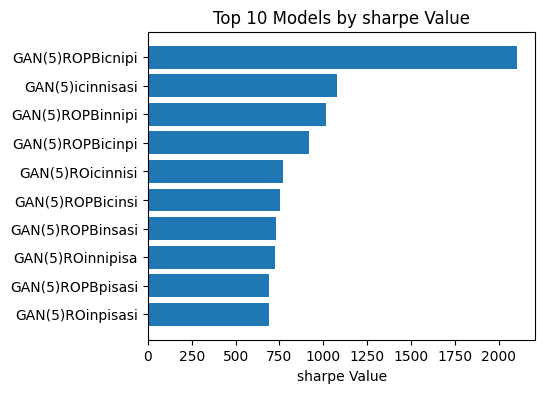

In [44]:
import matplotlib.pyplot as plt

result_sharpe = result.sort_values('sharpe', ascending=False).head(10)
plt.figure(figsize=(5, 4))
plt.barh(result_sharpe['model'], result_sharpe['sharpe'])
plt.xlabel('sharpe Value')
plt.title('Top 10 Models by sharpe Value')
plt.gca().invert_yaxis()
plt.show()


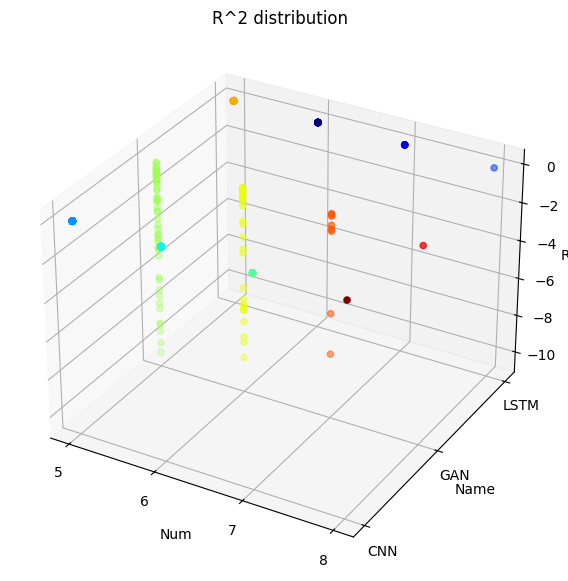

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df = result.copy()
df['name_num'] = df['name'].astype('category').cat.codes
df['num_num'] = df['num'].astype('category').cat.codes

# 변수수 - 모델 명 이라는 새로운 형태의 id 생성 -> 그래프 상의 label 색깔이 될꺼임
df['group_id'] = df['num_num'].astype(str) + '_' + df['name_num'].astype(str)

# 고유한 그룹별로 색상 코드 할당
unique_groups = df['group_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_groups)))
group_colors = {group: color for group, color in zip(unique_groups, colors)}

# 각 데이터 포인트에 대한 색상 배열 생성
point_colors = df['group_id'].map(group_colors)

# 3차원 산점도 그리기
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['num_num'], df['name_num'], df['R^2'], c=point_colors, marker='o')


ax.set_xlabel('Num')
ax.set_ylabel('Name')
ax.set_zlabel('R^2')

sorted_num = sorted(df['num'].unique())
ax.set_xticks(range(len(sorted_num)))
ax.set_xticklabels(sorted_num)

sorted_name = sorted(df['name'].unique())
ax.set_yticks(range(len(sorted_name)))
ax.set_yticklabels(sorted_name)

plt.title('R^2 distribution')
plt.show()


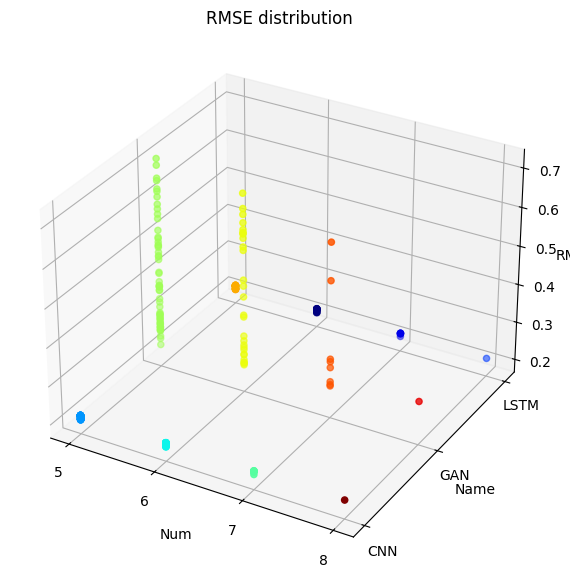

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df = result.copy()
df['name_num'] = df['name'].astype('category').cat.codes
df['num_num'] = df['num'].astype('category').cat.codes

# 변수수 - 모델 명 이라는 새로운 형태의 id 생성 -> 그래프 상의 label 색깔이 될꺼임
df['group_id'] = df['num_num'].astype(str) + '_' + df['name_num'].astype(str)

# 고유한 그룹별로 색상 코드 할당
unique_groups = df['group_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_groups)))
group_colors = {group: color for group, color in zip(unique_groups, colors)}

# 각 데이터 포인트에 대한 색상 배열 생성
point_colors = df['group_id'].map(group_colors)

# 3차원 산점도 그리기
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['num_num'], df['name_num'], df['RMSE'], c=point_colors, marker='o')


ax.set_xlabel('Num')
ax.set_ylabel('Name')
ax.set_zlabel('RMSE')

sorted_num = sorted(df['num'].unique())
ax.set_xticks(range(len(sorted_num)))
ax.set_xticklabels(sorted_num)

sorted_name = sorted(df['name'].unique())
ax.set_yticks(range(len(sorted_name)))
ax.set_yticklabels(sorted_name)

plt.title('RMSE distribution')
plt.show()


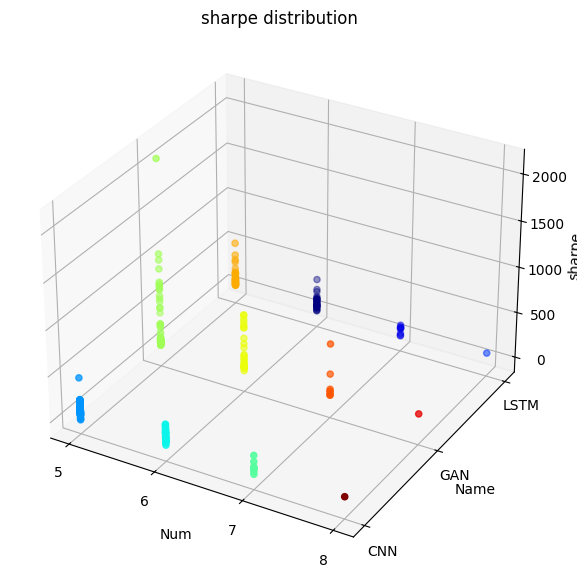

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df = result.copy()
df['name_num'] = df['name'].astype('category').cat.codes
df['num_num'] = df['num'].astype('category').cat.codes

# 변수수 - 모델 명 이라는 새로운 형태의 id 생성 -> 그래프 상의 label 색깔이 될꺼임
df['group_id'] = df['num_num'].astype(str) + '_' + df['name_num'].astype(str)

# 고유한 그룹별로 색상 코드 할당
unique_groups = df['group_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_groups)))
group_colors = {group: color for group, color in zip(unique_groups, colors)}

# 각 데이터 포인트에 대한 색상 배열 생성
point_colors = df['group_id'].map(group_colors)

# 3차원 산점도 그리기
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['num_num'], df['name_num'], df['sharpe'], c=point_colors, marker='o')


ax.set_xlabel('Num')
ax.set_ylabel('Name')
ax.set_zlabel('sharpe')

sorted_num = sorted(df['num'].unique())
ax.set_xticks(range(len(sorted_num)))
ax.set_xticklabels(sorted_num)

sorted_name = sorted(df['name'].unique())
ax.set_yticks(range(len(sorted_name)))
ax.set_yticklabels(sorted_name)

plt.title('sharpe distribution')
plt.show()


<io>
    out of sampling 분석 결과 CNN, GAN, LSTM 모형 중 RMSE, R^2 등으로 정확도를 추정하였을 경우, CNN, LSTM 모형이 더욱 안정적인 듯한 분포를 보였다. <br>
    sharpe ratio, 즉 이익을 얻을 가능성이 높은 것은 GAN 모형으로 나타났지만, 이는 정확도가 높지 않은 예측값으로 인해 예측 값이 overestimate 되었을 가능성이 존재한다. <br>
    탑 10위 안의 모델은 보통 변수를 5개 쓴 경우가 많았는데, 이는 변수가 너무 적어, 다른 변수가 예측에 정확도를 낮추는 것으로 예상이 된다.<br>
    딥러닝의 특성 상, 더 많은 변수가 들어갈 수록 달라질 것으로 예상되며, 포트폴리오 구성 역시 시가총액이 큰 기업에만 집중되는 것이 아닌, 다양한 방식을 통하여 해야 기업특성 변수가 유의미 할 것으로 예상되며 <br>
    Gan 모형 역시 조금 더 엄밀하게 생성, 판별기를 형성해야 될 것으로 예상이 된다.